We will start by downloading a sample mesh for the geometric texture that we would like to synthesize. 

In [ ]:
import constants
from process_data import files_utils

target_path = f'{constants.DATA_ROOT}/cloud.zip'
files_utils.download_file_from_google_drive('1e9vpySX4WUic09JGk7-LV_h8V6H4Nb_I', target_path)
files_utils.decompress_data(target_path)


Lets have a look on our *reference* texture.

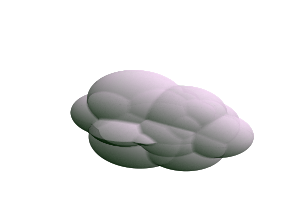

In [3]:
%matplotlib inline
from process_data import mesh_plotter
import matplotlib.pyplot as plt

mesh_plotter.plot_mesh(f'{constants.RAW_MESHES}/cloud')


Now, we will create our training data. This will take a ~1 hour.

In [1]:
from custom_types import CUDA, CPU
from process_data.ground_truth_optimization import GroundTruthGenerator
import options

args = options.GtOptions(tag='demo', mesh_name='cloud', template_name='sphere', num_levels=6)
device =  CUDA(0)
gt_gen = GroundTruthGenerator(args, device)
gt_gen.generate_ground_truth_meshes()


cloud_demo Level: 5: 100%|██████████| 3000/3000 [09:49<00:00,  5.21it/s, e_g=0.179, e_l=-1.09, gravity=0.0639, dis_s2t=0.299, dis_t2s=0.298, n_s2t=-.0013, n_t2s=-.996]  


Here are is *ground truth* training sequence.

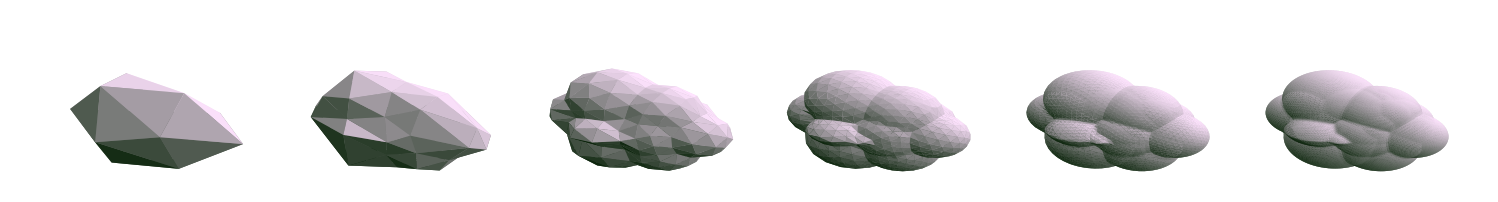

In [3]:
gt_paths = [f'{constants.DATA_ROOT}/cloud/cloud_level{i:02d}.obj' for i in range(6)]
mesh_plotter.plot_mesh(*gt_paths)

Finally we can train a *deep geometric texture synthesis* model. This will take ~2 hours.

In [4]:
from training import Trainer

args = options.TrainOption(tag='demo', mesh_name='cloud', template_name='sphere', num_levels=6)
trainer = Trainer(args, device)
trainer.train()

cloud_demo Level: 0:   0%|          | 0/2000 [00:00<?, ?it/s]

init SingleMeshGenerator model
init SingleMeshDiscriminator model


cloud_demo Level: 5: 100%|██████████| 2000/2000 [46:08<00:00,  1.34s/it, d_fake=-.126, d_real=-.0491, g_fake=-.126, g_rec=0.00209]  


Now we can use our model to synthesize the geometric texture on other meshes.

loading options from /home/amir/projects/geometric-textures/checkpoints/cloud_demo/options.pkl
loading SingleMeshGenerator model from /home/amir/projects/geometric-textures/checkpoints/cloud_demo/SingleMeshGenerator.pth


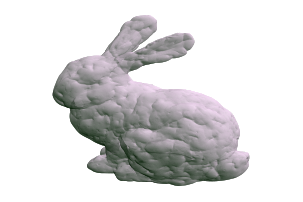

In [3]:
from dgts_base import Mesh2Mesh
from process_data import mesh_utils

m2m = Mesh2Mesh(args, CPU)
mesh = mesh_utils.load_real_mesh('bunny', 0, True)
out = m2m(mesh, 2, 5, 0)
out.plot()

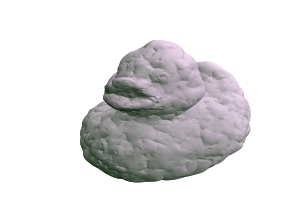

In [2]:
mesh = mesh_utils.load_real_mesh('duck', 0, True)
out = m2m(mesh, 2, 5, 0)
out.plot()